In [104]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

IMG_SIZE = 320
BATCH_SIZE = 16
EPOCHS_STAGE1 = 6     # frozen backbone
EPOCHS_STAGE2 = 8     # fine-tuning
PATIENCE = 3          # early stopping

Using device: cuda


In [105]:
import os
import pandas as pd

DATASET_DIR = "dataset"

records = []
for label_name, label_value in [("tumor", 1), ("non_tumor", 0)]:
    folder = os.path.join(DATASET_DIR, label_name)
    for fname in os.listdir(folder):
        if not fname.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        parts = fname.split("_")
        patient_id = parts[0]
        sequence = parts[1] if len(parts) > 1 else "UNK"
        records.append({
            "image_path": os.path.join(folder, fname),
            "label": label_value,
            "patient_id": patient_id,
            "sequence": sequence
        })
df = pd.DataFrame(records)
df.to_csv("dataset/metadata.csv", index=False)

In [106]:
df.to_csv("dataset/metadata.csv", index=False)
print("Saved metadata.csv with", len(df), "images")

Saved metadata.csv with 6604 images


In [107]:
print(df["label"].value_counts())
print("Unique patients:", df["patient_id"].nunique())

label
1    3952
0    2652
Name: count, dtype: int64
Unique patients: 52


In [108]:
import random
import matplotlib.pyplot as plt

def visualize_samples(df, class_name, n=6):
    """
    Visualize n random samples from a given class
    """
    subset = df[df["label"] == (1 if class_name == "tumor" else 0)]
    samples = subset.sample(n=min(n, len(subset)), random_state=42)

    plt.figure(figsize=(15, 5))
    
    for i, (_, row) in enumerate(samples.iterrows()):
        img = Image.open(row["image_path"]).convert("L")

        plt.subplot(1, n, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(
            f"Class: {class_name}\n"
            f"Patient: {row['patient_id']}\n"
            f"Seq: {row['sequence']}"
        )

    plt.suptitle(f"Sample {class_name.upper()} Images", fontsize=14)
    plt.show()

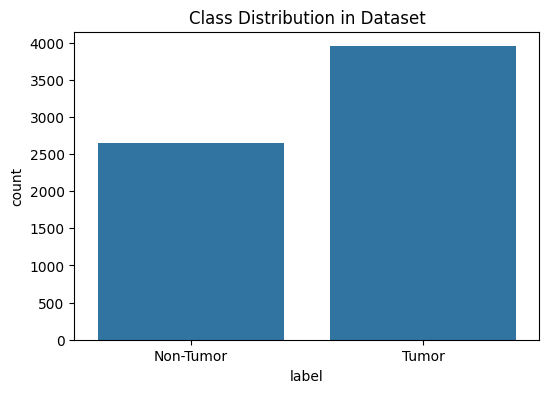

In [110]:
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="label", data=df)
plt.xticks([0,1], ["Non-Tumor", "Tumor"])
plt.title("Class Distribution in Dataset")
plt.show()

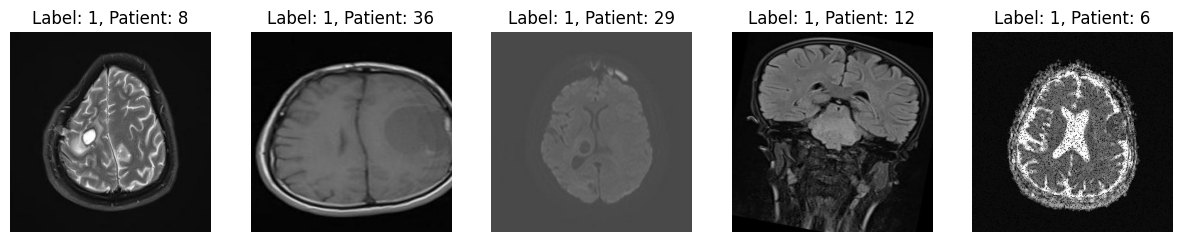

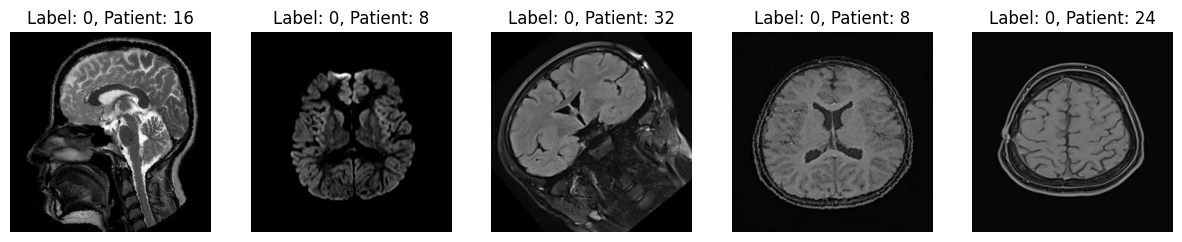

In [111]:
from PIL import Image
import matplotlib.pyplot as plt
import random

def show_random_images(df, num_images=5, label=None):
    if label is not None:
        df = df[df['label'] == label]
        
    samples = df.sample(num_images)
    plt.figure(figsize=(15,3))
    
    for i, row in enumerate(samples.itertuples()):
        img = Image.open(row.image_path).convert("RGB")
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"Label: {row.label}, Patient: {row.patient_id}")
        plt.axis("off")
    plt.show()

# Show 5 random tumor images
show_random_images(df, num_images=5, label=1)

# Show 5 random non-tumor images
show_random_images(df, num_images=5, label=0)

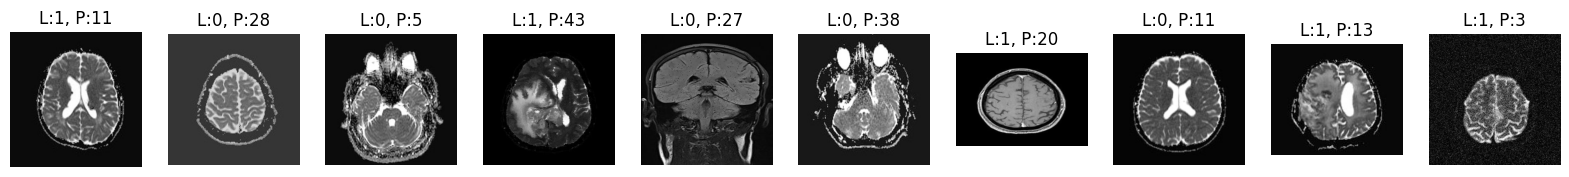

In [112]:
def show_mixed_grid(df, num_images=10):
    samples = df.sample(num_images)
    plt.figure(figsize=(20,4))
    
    for i, row in enumerate(samples.itertuples()):
        img = Image.open(row.image_path).convert("RGB")
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f"L:{row.label}, P:{row.patient_id}")
        plt.axis("off")
    plt.show()

show_mixed_grid(df, num_images=10)

In [113]:
from sklearn.model_selection import train_test_split

SEED = 42

patients = df["patient_id"].unique()

train_patients, test_patients = train_test_split(
    patients,
    test_size=0.2,
    random_state=SEED
)

train_df = df[df.patient_id.isin(train_patients)].reset_index(drop=True)
test_df  = df[df.patient_id.isin(test_patients)].reset_index(drop=True)

print("Train patients:", len(train_patients))
print("Test patients:", len(test_patients))
print("Train images:", len(train_df))
print("Test images:", len(test_df))

Train patients: 41
Test patients: 11
Train images: 5144
Test images: 1460


In [114]:
from torchvision import transforms
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),
        scale=(0.95, 1.05)
    ),
    transforms.ColorJitter(brightness=0.08, contrast=0.08),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [115]:
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row.image_path).convert("RGB")
        img = self.transform(img)
        label = torch.tensor(row.label, dtype=torch.float32)
        return img, label

In [116]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16  

train_loader = DataLoader(
    MRIDataset(train_df, train_tfms),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,   # <- Windows + Jupyter safe
    pin_memory=True
)

test_loader = DataLoader(
    MRIDataset(test_df, test_tfms),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,   # <- Windows + Jupyter safe
    pin_memory=True
)

In [117]:
# CELL 5
import timm

class EfficientNetB3Custom(nn.Module):
    def __init__(self, dropout=0.7):
        super().__init__()
        self.backbone = timm.create_model("efficientnet_b3", pretrained=True, num_classes=0)
        nf = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(nf, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)
        out = self.classifier(feats)
        return out

model = EfficientNetB3Custom(dropout=0.7).to(DEVICE)
print("Model device:", next(model.parameters()).device)

Model device: cuda:0


In [118]:
model = EfficientNetB3Custom().to(DEVICE)

for param in model.backbone.parameters():
    param.requires_grad = False

In [119]:
LABEL_SMOOTHING = 0.05
def smooth_targets(targets, smoothing=LABEL_SMOOTHING):
    # targets: tensor float {0,1}
    # smoothed: targets*(1-s) + 0.5*s  -> pulls labels toward 0.5
    return targets * (1 - smoothing) + 0.5 * smoothing

criterion = nn.BCEWithLogitsLoss()
# Stage-1 optimizer: only head parameters (backbone frozen below)
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=3e-4, weight_decay=5e-4)


In [120]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

from IPython.display import clear_output

In [121]:
def train_one_epoch(model, loader, optimizer, criterion, smoothing=LABEL_SMOOTHING):
    model.train()
    losses = []
    all_probs = []
    all_targets = []

    for images, targets in loader:
        images = images.to(DEVICE)
        targets = targets.float().to(DEVICE)

        optimizer.zero_grad()
        logits = model(images)
        # apply manual label smoothing to targets for loss calculation
        targets_smoothed = smooth_targets(targets, smoothing).unsqueeze(1).to(DEVICE)
        loss = criterion(logits, targets_smoothed)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        probs = torch.sigmoid(logits).detach().cpu().numpy().ravel()
        all_probs.extend(probs)
        all_targets.extend(targets.cpu().numpy())

    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)
    bin_preds = (all_probs >= 0.5).astype(int)

    metrics = {}
    metrics["loss"] = np.mean(losses)
    metrics["acc"] = accuracy_score(all_targets, bin_preds)
    metrics["precision"] = precision_score(all_targets, bin_preds, zero_division=0)
    metrics["recall"] = recall_score(all_targets, bin_preds, zero_division=0)
    metrics["f1"] = f1_score(all_targets, bin_preds, zero_division=0)
    metrics["auc"] = roc_auc_score(all_targets, all_probs) if len(np.unique(all_targets)) > 1 else float("nan")

    return metrics, all_probs, all_targets


@torch.no_grad()
def validate_one_epoch(model, loader, criterion):
    model.eval()
    losses = []
    all_probs = []
    all_targets = []

    for images, targets in loader:
        images = images.to(DEVICE)
        targets = targets.float().to(DEVICE)

        logits = model(images)
        targets_smoothed = smooth_targets(targets, LABEL_SMOOTHING).unsqueeze(1).to(DEVICE)
        loss = criterion(logits, targets_smoothed)

        losses.append(loss.item())
        probs = torch.sigmoid(logits).cpu().numpy().ravel()
        all_probs.extend(probs)
        all_targets.extend(targets.cpu().numpy())

    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)
    bin_preds = (all_probs >= 0.5).astype(int)

    metrics = {}
    metrics["loss"] = np.mean(losses)
    metrics["acc"] = accuracy_score(all_targets, bin_preds)
    metrics["precision"] = precision_score(all_targets, bin_preds, zero_division=0)
    metrics["recall"] = recall_score(all_targets, bin_preds, zero_division=0)
    metrics["f1"] = f1_score(all_targets, bin_preds, zero_division=0)
    metrics["auc"] = roc_auc_score(all_targets, all_probs) if len(np.unique(all_targets)) > 1 else float("nan")

    return metrics, all_probs, all_targets

In [122]:
history = {k: [] for k in [
    "train_loss","val_loss","train_acc","val_acc",
    "train_precision","val_precision","train_recall","val_recall",
    "train_f1","val_f1","train_auc","val_auc"
]}

def plot_history(history):
    plt.figure(figsize=(14,8))
    plt.subplot(2,2,1)
    plt.plot(history["train_loss"], label="train")
    plt.plot(history["val_loss"], label="val")
    plt.title("Loss"); plt.legend()

    plt.subplot(2,2,2)
    plt.plot(history["train_auc"], label="train")
    plt.plot(history["val_auc"], label="val")
    plt.title("ROC-AUC"); plt.legend()

    plt.subplot(2,2,3)
    plt.plot(history["train_f1"], label="train")
    plt.plot(history["val_f1"], label="val")
    plt.title("F1-score"); plt.legend()

    plt.subplot(2,2,4)
    plt.plot(history["train_recall"], label="train")
    plt.plot(history["val_recall"], label="val")
    plt.title("Recall"); plt.legend()

    plt.tight_layout()
    plt.show()

[Stage1 Frozen] Epoch 6/6
Train AUC 0.9441 | Val AUC 0.9061


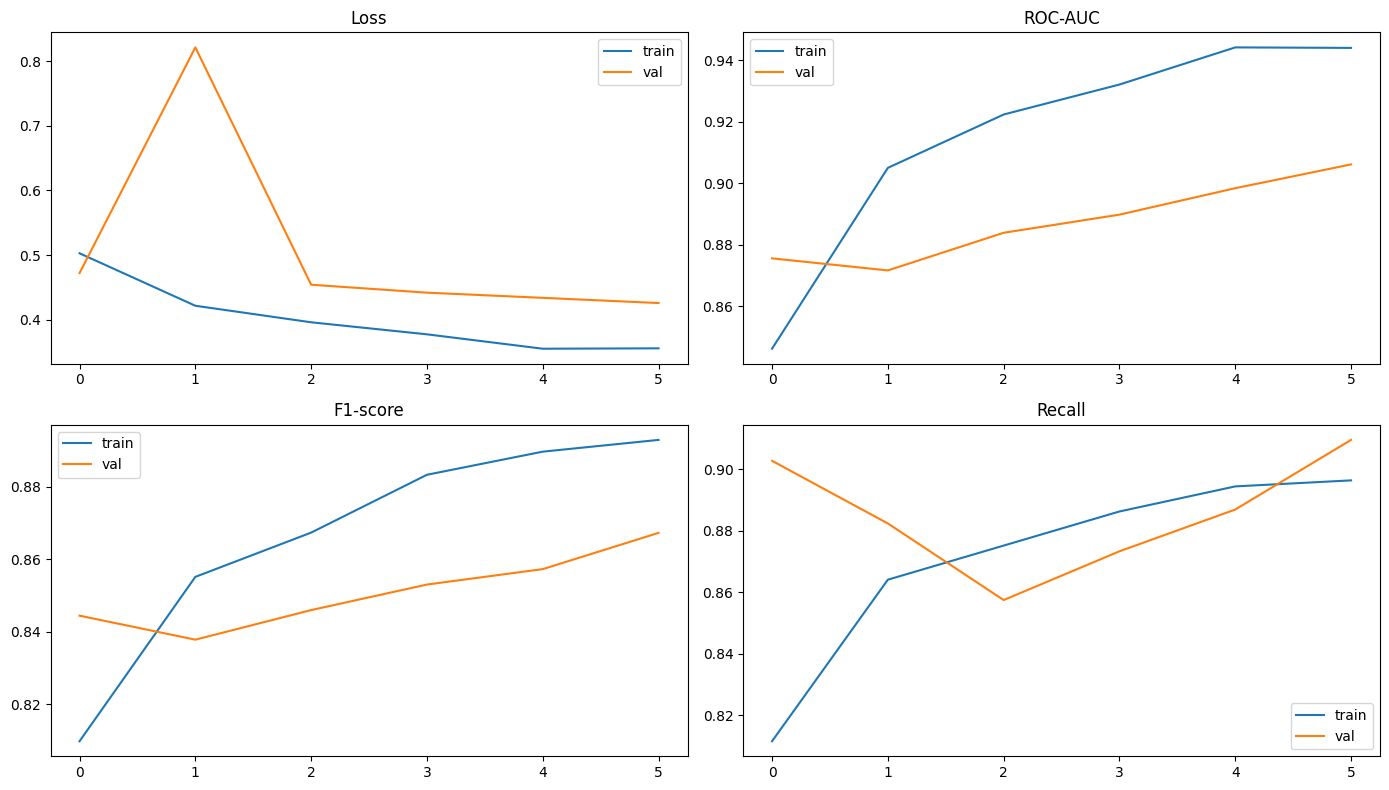

In [123]:
for p in model.backbone.parameters():
    p.requires_grad = False

# Re-create optimizer for head params only
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=3e-4, weight_decay=5e-4)

best_val_auc = -1.0
epochs_no_improve = 0

for epoch in range(EPOCHS_STAGE1):
    train_m, _, _ = train_one_epoch(model, train_loader, optimizer, criterion, smoothing=LABEL_SMOOTHING)
    val_m, val_probs, val_targets = validate_one_epoch(model, test_loader, criterion)

    # save metrics
    history["train_loss"].append(train_m["loss"]); history["val_loss"].append(val_m["loss"])
    history["train_acc"].append(train_m["acc"]); history["val_acc"].append(val_m["acc"])
    history["train_precision"].append(train_m["precision"]); history["val_precision"].append(val_m["precision"])
    history["train_recall"].append(train_m["recall"]); history["val_recall"].append(val_m["recall"])
    history["train_f1"].append(train_m["f1"]); history["val_f1"].append(val_m["f1"])
    history["train_auc"].append(train_m["auc"]); history["val_auc"].append(val_m["auc"])

    # early stopping by val AUC
    if not np.isnan(val_m["auc"]) and val_m["auc"] > best_val_auc:
        best_val_auc = val_m["auc"]
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model (Stage1) with val AUC {best_val_auc:.4f}")
    else:
        epochs_no_improve += 1

    clear_output(wait=True)
    print(f"[Stage1 Frozen] Epoch {epoch+1}/{EPOCHS_STAGE1}")
    print(f"Train AUC {train_m['auc']:.4f} | Val AUC {val_m['auc']:.4f}")
    plot_history(history)

    if epochs_no_improve >= PATIENCE:
        print("Early stopping Stage1")
        break

[Stage2 Fine-tune] Epoch 8/8
Train AUC 0.9998 | Val AUC 0.9662


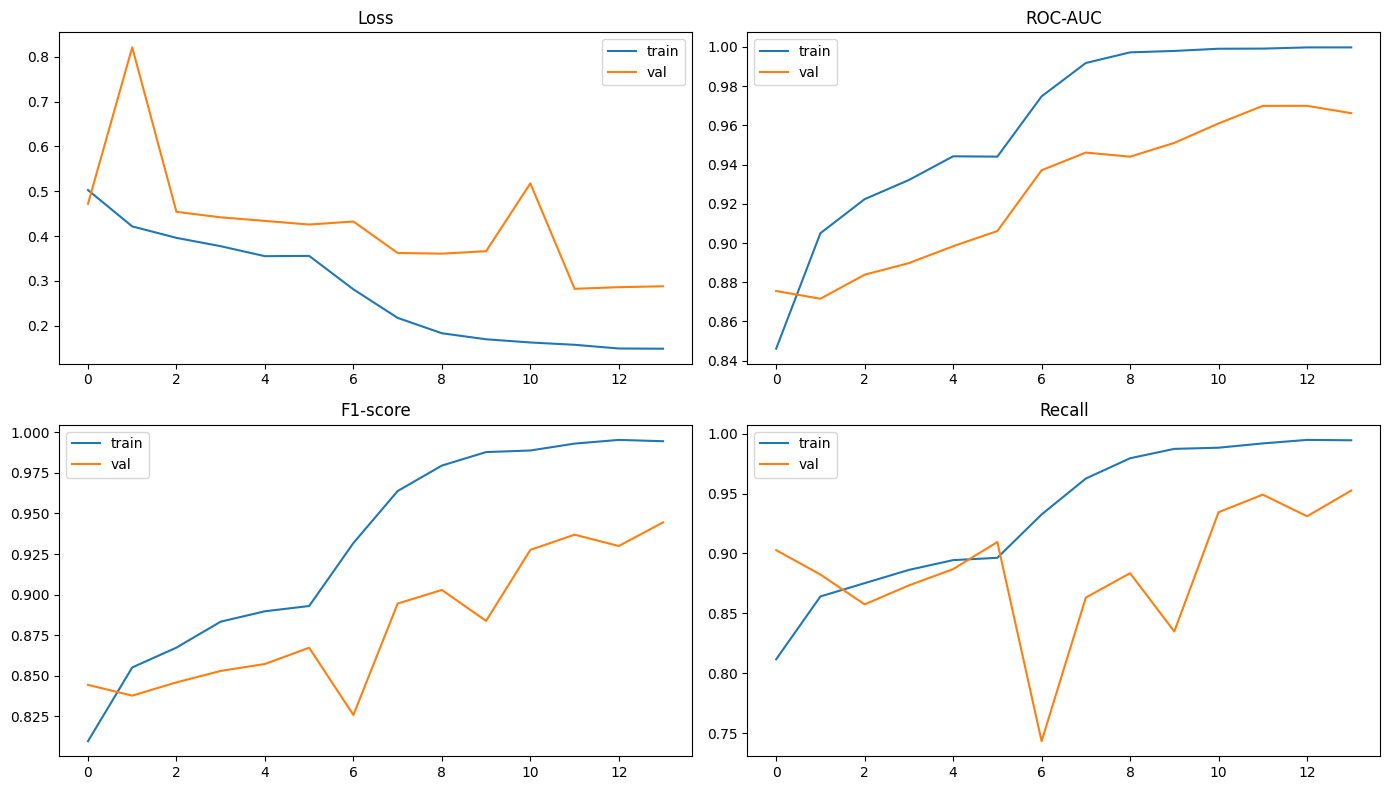

In [124]:
# Unfreeze backbone
for p in model.backbone.parameters():
    p.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-4)

epochs_no_improve = 0
for epoch in range(EPOCHS_STAGE2):
    train_m, _, _ = train_one_epoch(model, train_loader, optimizer, criterion, smoothing=LABEL_SMOOTHING)
    val_m, val_probs, val_targets = validate_one_epoch(model, test_loader, criterion)

    # append metrics
    history["train_loss"].append(train_m["loss"]); history["val_loss"].append(val_m["loss"])
    history["train_acc"].append(train_m["acc"]); history["val_acc"].append(val_m["acc"])
    history["train_precision"].append(train_m["precision"]); history["val_precision"].append(val_m["precision"])
    history["train_recall"].append(train_m["recall"]); history["val_recall"].append(val_m["recall"])
    history["train_f1"].append(train_m["f1"]); history["val_f1"].append(val_m["f1"])
    history["train_auc"].append(train_m["auc"]); history["val_auc"].append(val_m["auc"])

    if not np.isnan(val_m["auc"]) and val_m["auc"] > best_val_auc:
        best_val_auc = val_m["auc"]
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")
        print(f"Saved best model (Stage2) with val AUC {best_val_auc:.4f}")
    else:
        epochs_no_improve += 1

    clear_output(wait=True)
    print(f"[Stage2 Fine-tune] Epoch {epoch+1}/{EPOCHS_STAGE2}")
    print(f"Train AUC {train_m['auc']:.4f} | Val AUC {val_m['auc']:.4f}")
    plot_history(history)

    if epochs_no_improve >= PATIENCE:
        print("Early stopping Stage2")
        break

In [126]:
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model.eval()
print("Loaded best_model.pth (val AUC = {:.4f})".format(best_val_auc))

# Quick full-validation numbers (collect probs & metrics)
val_m, val_probs, val_targets = validate_one_epoch(model, test_loader, criterion)

print("Final validation metrics:")
for k,v in val_m.items():
    if isinstance(v, float):
        print(f"  {k}: {v:.4f}")
    else:
        print(f"  {k}: {v}")

C:\Users\Tabassum\AppData\Local\Temp\ipykernel_15160\1133110761.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_lo

Loaded best_model.pth (val AUC = 0.9700)
Final validation metrics:
  loss: 0.2859
  acc: 0.9151
  precision: 0.9289
  recall: 0.9310
  f1: 0.9299
  auc: 0.9700


In [127]:
import numpy as np
from sklearn.metrics import accuracy_score

val_probs = np.array(val_probs)
val_targets = np.array(val_targets)

best_acc = 0.0
best_t = 0.5
for t in np.linspace(0.1, 0.9, 81):
    preds = (val_probs >= t).astype(int)
    acc = accuracy_score(val_targets, preds)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print(f"Best threshold by val accuracy: {best_t:.3f}  (accuracy={best_acc:.4f})")
# Save threshold
BEST_THRESHOLD = float(best_t)

Best threshold by val accuracy: 0.380  (accuracy=0.9226)


In [130]:
torch.save(model.state_dict(), "last_model.pth")   # final
print("Saved last_model.pth and best_model.pth")

def predict_image_single(path, model, transform, device, threshold=BEST_THRESHOLD):
    model.eval()

    img = Image.open(path)          # ❌ no .convert("L")
    inp = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logit = model(inp)
        prob = float(torch.sigmoid(logit).cpu().numpy().ravel()[0])

    return {
        "probability": prob,
        "prediction": "Tumor" if prob >= threshold else "Non-Tumor"
    }

# quick example
sample_path = test_df.sample(1).iloc[0]["image_path"]
print("Sample inference:", predict_image_single(sample_path, model, test_tfms, DEVICE))

Saved last_model.pth and best_model.pth
Sample inference: {'probability': 0.06499806046485901, 'prediction': 'Non-Tumor'}


In [131]:
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image


In [141]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor):
        self.model.zero_grad()
        logits = self.model(input_tensor)
        score = logits[:, 0]
        score.backward()

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = F.relu(cam)
        cam = cam - cam.min()
        cam = cam / (cam.max() + 1e-8)

        return cam.squeeze().cpu().numpy()

In [142]:
def find_last_conv(model):
    last_conv = None
    last_name = None
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            last_conv = module
            last_name = name
    print("Selected conv layer:", last_name)
    return last_conv
target_layer = find_last_conv(model.backbone)
gradcam = GradCAM(model, target_layer)

Selected conv layer: conv_head


In [143]:
def compute_brain_mask(img_np, blur_ksize=5):
    import cv2
    import numpy as np

    if img_np.ndim == 3:
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    else:
        gray = img_np.copy()

    gray = (gray - gray.min()) / (gray.max() - gray.min() + 1e-8)
    gray_u8 = np.uint8(gray * 255)
    blur = cv2.GaussianBlur(gray_u8, (blur_ksize, blur_ksize), 0)
    _, mask = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    mask = (mask > 0).astype(np.float32)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    return mask

In [144]:
def normalize_and_mask_cam(cam, mask=None, vmin_pct=5, vmax_pct=99):
    import numpy as np

    cam = cam.copy()
    lo = np.percentile(cam, vmin_pct)
    hi = np.percentile(cam, vmax_pct)
    cam = np.clip(cam, lo, hi)
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

    if mask is not None:
        cam = cam * mask
        if cam.max() > 0:
            cam = cam / (cam.max() + 1e-8)

    return cam

In [145]:
def visual_inference_improved(
    image_path,
    model,
    transform,
    device,
    gradcam,
    alpha=0.5,
    cam_vmin_pct=5,
    cam_vmax_pct=99
):
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    model.eval()
    img_pil = Image.open(image_path)
    img_np = np.array(img_pil.resize((IMG_SIZE, IMG_SIZE)))

    if img_np.ndim == 2:
        img_disp = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
    else:
        img_disp = img_np.copy()

    input_tensor = transform(img_pil).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor)
        prob = float(torch.sigmoid(logits).cpu().numpy().ravel()[0])

    cam = gradcam.generate(input_tensor)
    cam_resized = cv2.resize(cam, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR)

    mask = compute_brain_mask(img_disp)
    cam_masked = normalize_and_mask_cam(
        cam_resized, mask, cam_vmin_pct, cam_vmax_pct
    )

    heatmap = cv2.applyColorMap(
        (cam_masked * 255).astype(np.uint8), cv2.COLORMAP_JET
    )
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = (img_disp * (1 - alpha) + heatmap * alpha).astype(np.uint8)

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1); plt.imshow(img_disp); plt.title("Original MRI"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(cam_masked, cmap="jet"); plt.title("Grad-CAM"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay  Prob={prob:.3f}"); plt.axis("off")
    plt.show()

    return {
        "probability": prob,
        "prediction": "Tumor" if prob >= BEST_THRESHOLD else "Non-Tumor"
    }

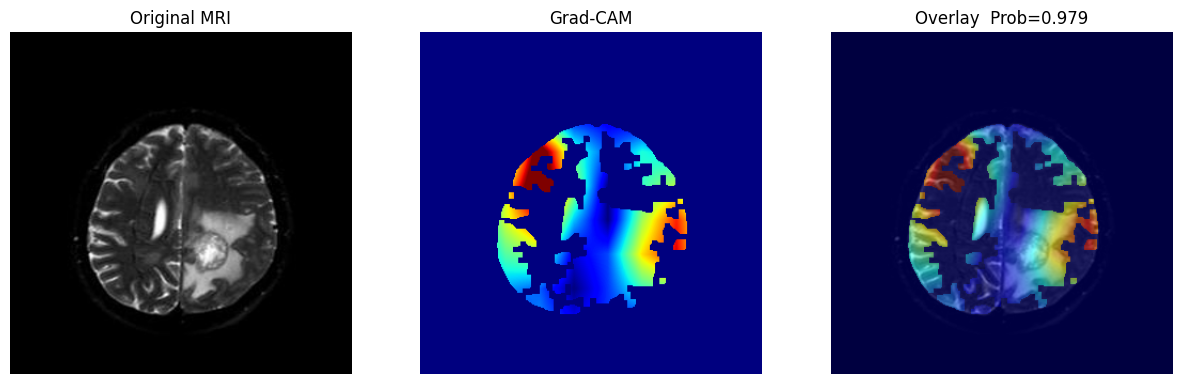

{'probability': 0.9785153865814209, 'prediction': 'Tumor'}


In [147]:
sample_path = test_df.sample(1).iloc[0]["image_path"]
result = visual_inference_improved(
    sample_path,
    model,
    test_tfms,
    DEVICE,
    gradcam
)
print(result)

In [150]:
def extract_vision_evidence(image_path, model, transform, device, gradcam):
    model.eval()

    img = Image.open(image_path)
    inp = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logit = model(inp)
        prob = float(torch.sigmoid(logit).cpu().numpy().ravel()[0])

    cam = gradcam.generate(inp)

    # summarize CAM
    cam_strength = float(cam.max())
    cam_focus = "focal" if cam_strength > 0.6 else "diffuse"

    return {
        "tumor_probability": round(prob, 3),
        "prediction": "Tumor" if prob >= BEST_THRESHOLD else "Non-Tumor",
        "cam_strength": round(cam_strength, 3),
        "cam_pattern": cam_focus
    }

In [151]:
medical_knowledge = [
    "Brain tumors often present as focal regions of abnormal signal intensity on MRI.",
    "Gliomas may show heterogeneous intensity and irregular borders.",
    "Non-tumor MRI scans typically lack mass effect or focal enhancement.",
    "Grad-CAM highlights regions contributing most to model decisions.",
    "MRI findings alone are insufficient for diagnosis and require clinical correlation."
]

In [152]:
def retrieve_medical_context(vision_evidence, knowledge_base, k=3):
    query_terms = []
    
    if vision_evidence["prediction"] == "Tumor":
        query_terms.append("tumor")
    if vision_evidence["cam_pattern"] == "focal":
        query_terms.append("focal")

    retrieved = []
    for sentence in knowledge_base:
        if any(term.lower() in sentence.lower() for term in query_terms):
            retrieved.append(sentence)

    return retrieved[:k]

In [153]:
def visual_rag_explanation(vision_evidence, retrieved_context):
    explanation = f"""
Vision Model Analysis:
- Prediction: {vision_evidence['prediction']}
- Tumor Probability: {vision_evidence['tumor_probability']}
- Visual Attention Pattern: {vision_evidence['cam_pattern']} activation

Explanation:
The vision model identified patterns in the MRI that are associated with the predicted class.
Grad-CAM visualization shows a {vision_evidence['cam_pattern']} region of importance,
suggesting areas of the image that influenced the decision.

Medical Context:
"""

    for ctx in retrieved_context:
        explanation += f"- {ctx}\n"

    explanation += """
Important Note:
This AI-based assessment is intended for research and decision support only.
It does not replace professional medical diagnosis.
"""

    return explanation.strip()

In [154]:
sample_path = test_df.sample(1).iloc[0]["image_path"]

vision_evidence = extract_vision_evidence(
    sample_path, model, test_tfms, DEVICE, gradcam
)

retrieved_context = retrieve_medical_context(
    vision_evidence, medical_knowledge
)

final_report = visual_rag_explanation(
    vision_evidence, retrieved_context
)

print(final_report)

Vision Model Analysis:
- Prediction: Tumor
- Tumor Probability: 0.937
- Visual Attention Pattern: focal activation

Explanation:
The vision model identified patterns in the MRI that are associated with the predicted class.
Grad-CAM visualization shows a focal region of importance,
suggesting areas of the image that influenced the decision.

Medical Context:
- Brain tumors often present as focal regions of abnormal signal intensity on MRI.
- Non-tumor MRI scans typically lack mass effect or focal enhancement.

Important Note:
This AI-based assessment is intended for research and decision support only.
It does not replace professional medical diagnosis.
